#K-means for player clustering
In this notebook we are going to train an **unsupervised machine learning** algorithm called **K-means**.

K-means clustering is a method of vector quantization, that **aims to partition n observations into k clusters** in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid).

In other words, **K-means is able to find relationships in data and create groups of similar characteristics.**

We will use a dataset **('FB_stats.xlsx')** that I scraped from Fbref with game variables of different **Big 5 league players** to train a K-means and **group players based on similarity factors**.

We start by importing the necessaries libraries and uploading the excel file('FB_stats.xlsx'). 

In [ ]:
# import libraries
import pandas as pd
import numpy as np
from PIL import Image
from io import BytesIO
import requests
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel('/content/FB_stats.xlsx')
df.head()

,Rk,Player,Positions,Shot Creating Actions,Goal Creating Actions,Aerial duels Won%,xG/-90,On-Off,Touches Mid 3rd,Touches Att 3rd,...,Assists,Key Passes,Passes Penalti Area,Crosses Penalti Area,Progressive passes,90s played,Shot on target,npxG,Nation,Competition
0,1.0,Brenden Aaronson,MFFW,2.49,0.31,15.0,0.04,0.54,21.4,22.30,...,0.16,1.56,0.63,0.31,1.41,6.4,0.47,0.19,us USA,eng Premier League
1,2.0,Yunis Abdelhamid,DF,0.44,0.00,73.1,0.00,0.00,22.1,2.22,...,0.00,0.00,0.11,0.00,3.11,9.0,0.00,0.04,ma MAR,fr Ligue 1
2,3.0,Himad Abdelli,MF,3.33,0.00,0.0,-0.23,0.00,60.0,36.70,...,0.00,3.33,0.00,0.00,13.30,0.3,0.00,0.00,fr FRA,fr Ligue 1
3,4.0,Salis Abdul Samed,MF,0.89,0.00,36.4,1.06,1.03,50.1,11.30,...,0.00,0.44,0.56,0.11,3.00,9.0,0.11,0.03,gh GHA,fr Ligue 1
4,5.0,Laurent Abergel,MF,1.15,0.00,62.5,0.90,0.00,29.3,5.17,...,0.00,0.57,0.11,0.00,2.76,8.7,0.00,0.01,fr FRA,fr Ligue 1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755 entries, 0 to 2754
Data columns (total 44 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Rk                                             2755 non-null   float64
 1   Player                                         2755 non-null   object 
 2   Positions                                      2755 non-null   object 
 3   Shot Creating Actions                          2755 non-null   float64
 4   Goal Creating Actions                          2755 non-null   float64
 5   Aerial duels Won%                              2755 non-null   float64
 6   xG/-90                                         2755 non-null   float64
 7   On-Off                                         2755 non-null   float64
 8   Touches Mid 3rd                                2755 non-null   float64
 9   Touches Att 3rd                                2755 

Let's see all the positions names to filter the dataset per position.

In [ ]:
df['Positions'].unique()

array(['MFFW', 'DF', 'MF', 'FWMF', 'FW', 'FWDF', 'DFMF', 'GK', 'DFFW',
       'MFDF', '0.0'], dtype=object)

I want to train the K-means algorithm just for full backs that are classified as DF. The problem is that center backs are classified as DF as well, so I can't filter for just full backs. 

We will filter the dataset with ('DF','DFFW') positions in order to stay with defenders and more ofensive defenders.   

In [ ]:
positions = ['DF','DFFW']

In [ ]:
df = df[df['Positions'].isin(positions)]

For our clustering, we will consider players with more than 90's played, so let's filter the dataset accordingly.

In [ ]:
df = df[df['90s played'] >=5]

To simplify and not get an output with too many players, we will only analyze Premier League players.

In [ ]:
df['Competition'].unique()

array(['fr Ligue 1', 'eng Premier League', 'es La Liga', 'it Serie A',
       'de Bundesliga'], dtype=object)

Filtering the dataset by only Premier League players.

In [ ]:
df_eng = df[df['Competition'] == 'eng Premier League']

Next, let's filter the columns that are of interest to us for clustering.

In [ ]:
df_eng = df_eng[['Player','Shot Creating Actions',
       'Goal Creating Actions', 'Aerial duels Won%', 'xG/-90', 'On-Off',
       'Touches Mid 3rd', 'Touches Att 3rd', 'Touches Attacking Area',
       'Dribbles Succ', 'Success dribble%', 'Player dribbled past', 'Carries',
       'Total Distance', 'Progressive Distance', 'Progressive Carries',
       'Carries into final 3rd', 'Carries into Penalti Area',
       'Progressive passes received', 'Tackled dribbled%', 'Dribbled Past',
       'Sw (+40m width pass)', 'Ground passes', 'Low passes', 'High passes',
       'Completed passes into space between defenders', 'Completion total%',
       'TotDistance', 'PrgDistance', 'Completion short passes%',
       'Completion medium passes %', 'Completion long passes%', 'Assists',
       'Key Passes', 'Passes Penalti Area', 'Crosses Penalti Area',
       'Progressive passes', '90s played', 'Shot on target', 'npxG']]

All the metrics that I considered this model are calculated per 90 minutes played.
Below we have the name of column of each metric in the dataset and it's definition.

*   **'90s played**' - Minutes played divided by 90
*   **'TotDistance' -- Total distance** in yards, that completed passes have traveled in any direction

*   **'PrgDistance' -- Progressive passing distance** -
total distance, in yards, that completed passes have traveled towards the opponent's goal. Note: Passes away from opponent's goal are counted as zero progressive yards.

*   **'Key Passes'** - passes that directly lead to a shot (assisted shots)

*   **'Passes Penalti Area'** - completed passes into the 18-yard box
Not including set pieces

*   **'Crosses Penalti Area'** - completed crosses into the 18-yard box
Not including set pieces

*   **'Progressive Passes'** -
completed passes that move the ball towards the opponent's goal at least 10 yards from its furthest point in the last six passes, or any completed pass into the penalty area. Excludes passes from the defending 40% of the pitch

*   **'Completed passes into space between defenders'** -- Completed pass sent between back defenders into open space

*   **'Sw (+40m width pass)'** -- Passes that travel more than 40 yards of the width of the pitch

*   **'Ground passes'**

*   **'Low passes'** -- Passes that leave the ground, but stay below shoulder-level

*   **'High passes'** -- Passes that are above shoulder-level at the peak height

*   **'Assists'**

*   **'Progressive passes received'** 

*   **'Completion Total%' -- Pass Completion Percentage** 

*   **'Short completion passes %' -- Pass Completion Percentage**,
 passes between 5 and 15 yards

*   **'Medium completion passes %' -- Pass Completion Percentage**,
 passes between 15 and 30 yards

*    **'Long completion passes %' -- Pass Completion Percentage**,
 passes longer than 30 yards

*   **'Aerial duels won%'**

*   **'Tackled dribbled%'** -- Percentage of dribblers tackled
Dribblers tackled divided by dribblers tackled plus times dribbled past

*   **'Dribbled Past'** -- Number of times dribbled past by an opposing player

*   **'Touches Mid 3rd'** -- Touches in middle 1/3

*   **'Touches Att 3rd'** -- Touches in attacking 1/3

*   **'Touches Attacking Area'** -- Touches in attacking penalty area

*   **'Dribbles Succ'** -- nº successful dribbles

*   **'Success dribble%'** -- Percentage of dribbles completed successfully

*   **'Player dribbled past'** -- Number of players dribbled past

*   **'Carries'** -- Number of times the player controlled the ball with their feet

*   **'Total Distance'** -- Total distance, in yards, a player moved the ball while controlling it with their feet, in any direction

*   **'Progressive Distance' --  Carrying progressive distance** -
Total distance, in yards, a player moved the ball while controlling it with their feet towards the opponent's goal

*   **'Progressive Carries'** -- Carries that move the ball towards the opponent's goal at least 5 yards, or any carry into the penalty area. Excludes carries from the defending 40% of the pitch

*   **'Carries into final 3rd'** -- Carries that enter the 1/3 of the pitch closest to the goal

*   **'Carries into Penalti Area'** --  Carries into the 18-yard box

*    **Shot on target**

*   **'npxG'** - non penalty expected goals per 90 minutes played

*   **'Shot Creating Actions' -- Goal-Creating Actions** -
The two offensive actions directly leading to a goal, such as passes, dribbles and drawing fouls.

Note: A single player can receive credit for multiple actions and the shot-taker can also receive credit.

*   **'Goal Creating Actions'** - similar to the previous metrics but for goal situations

*   **'On-Off' -- xG Plus/Minus Net** -
Net expected goals per 90 minutes by the team while the player was on the pitch minus net expected goals per 90 minutes by the team while the player was off the pitch.

*   **xG+/-90 -- xG Plus/Minus** - 
Expected goals scored minus expected goals allowed by the team while the player was on the pitch per 90 minutes played.




In [ ]:
# info about premier league dataset
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 14 to 2225
Data columns (total 40 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Player                                         71 non-null     object 
 1   Shot Creating Actions                          71 non-null     float64
 2   Goal Creating Actions                          71 non-null     float64
 3   Aerial duels Won%                              71 non-null     float64
 4   xG/-90                                         71 non-null     float64
 5   On-Off                                         71 non-null     float64
 6   Touches Mid 3rd                                71 non-null     float64
 7   Touches Att 3rd                                71 non-null     float64
 8   Touches Attacking Area                         71 non-null     float64
 9   Dribbles Succ                                  71 non

Let's check if we have invalid values.

In [ ]:
pd.set_option('display.max_rows', 80)
df_eng.isnull().sum()

Player                                           0
Shot Creating Actions                            0
Goal Creating Actions                            0
Aerial duels Won%                                0
xG/-90                                           0
On-Off                                           0
Touches Mid 3rd                                  0
Touches Att 3rd                                  0
Touches Attacking Area                           0
Dribbles Succ                                    0
Success dribble%                                 0
Player dribbled past                             0
Carries                                          0
Total Distance                                   0
Progressive Distance                             0
Progressive Carries                              0
Carries into final 3rd                           0
Carries into Penalti Area                        0
Progressive passes received                      0
Tackled dribbled%              

Copy of df_eng

In [ ]:
df_3d = df_eng.copy()

Remove player identifiers and normalize our data with Min Max.

In [ ]:
from sklearn import preprocessing

player_names = df_eng['Player'].tolist() 

df_eng = df_eng.drop(['Player'], axis = 1) 

x = df_eng.values 
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

We use PCA here as a way to reduce our dimensions. Let's scale it down to 2 dimensions so we can see the data in a 2D plot with the K-means results.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
reduced = pd.DataFrame(pca.fit_transform(X_norm))
reduced.head()

,0,1
0,-0.639051,-0.338125
1,1.145303,0.432487
2,1.749324,1.003704
3,-0.534441,0.036560
4,-0.293951,-0.378632


Now that we've reduced the dimensions using PCA, we can plot our players and look for relationships in a 2D analysis.

However, this plot is just a plot of similarity between players since PC 1 and PC 2 are not useful variables for a technical team or a scouting team.

Now that we have a 2D similarity metric, we can apply K-means to create the similarity clusters but first we need to know how many clusters we want.

To know the adequate number of clusters ($K$) we use a method **called elbow**, applied below.
We then create a loop that will train 11 K-means models (for different $K$'s) and remove **WCSS** for each of the trainings.

WCSS is defined as the sum of the squared distance between each member of the cluster and its centroid.

Text(0, 0.5, 'WCSS')

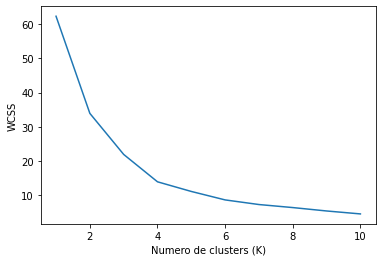

In [ ]:
from sklearn.cluster import KMeans

wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(reduced) 
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Numero de clusters (K)')
plt.ylabel('WCSS') 

By the elbow method, we consider it $K=6$ (as the elbow of our WCSS graph) as it is perhaps the value of from which WCSS stops dropping so fast.

So let's train a k-means for $K=6$ and see how it behaves.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)
kmeans = kmeans.fit(reduced)

labels = kmeans.predict(reduced)
clusters = kmeans.labels_.tolist()

After training and after using the trained model, each player in the dataset now has a number from 0 to 5 that represents their set.
Let's put this information in our reduced dataset and then plot it with the results of K-means.

In [ ]:
reduced['cluster'] = clusters
reduced['name'] = player_names
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced.head()

,x,y,cluster,name
0,-0.639051,-0.338125,5,Tosin Adarabioyo
1,1.145303,0.432487,3,Rayan Aït Nouri
2,1.749324,1.003704,3,Trent Alexander-Arnold
3,-0.534441,0.036560,5,Joachim Andersen
4,-0.293951,-0.378632,5,Armel Bella Kotchap


In this plot, each color represents a cluster. Now, it is part of our job to analyze the clusters and discover what these players have in common to be in the same cluster.

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


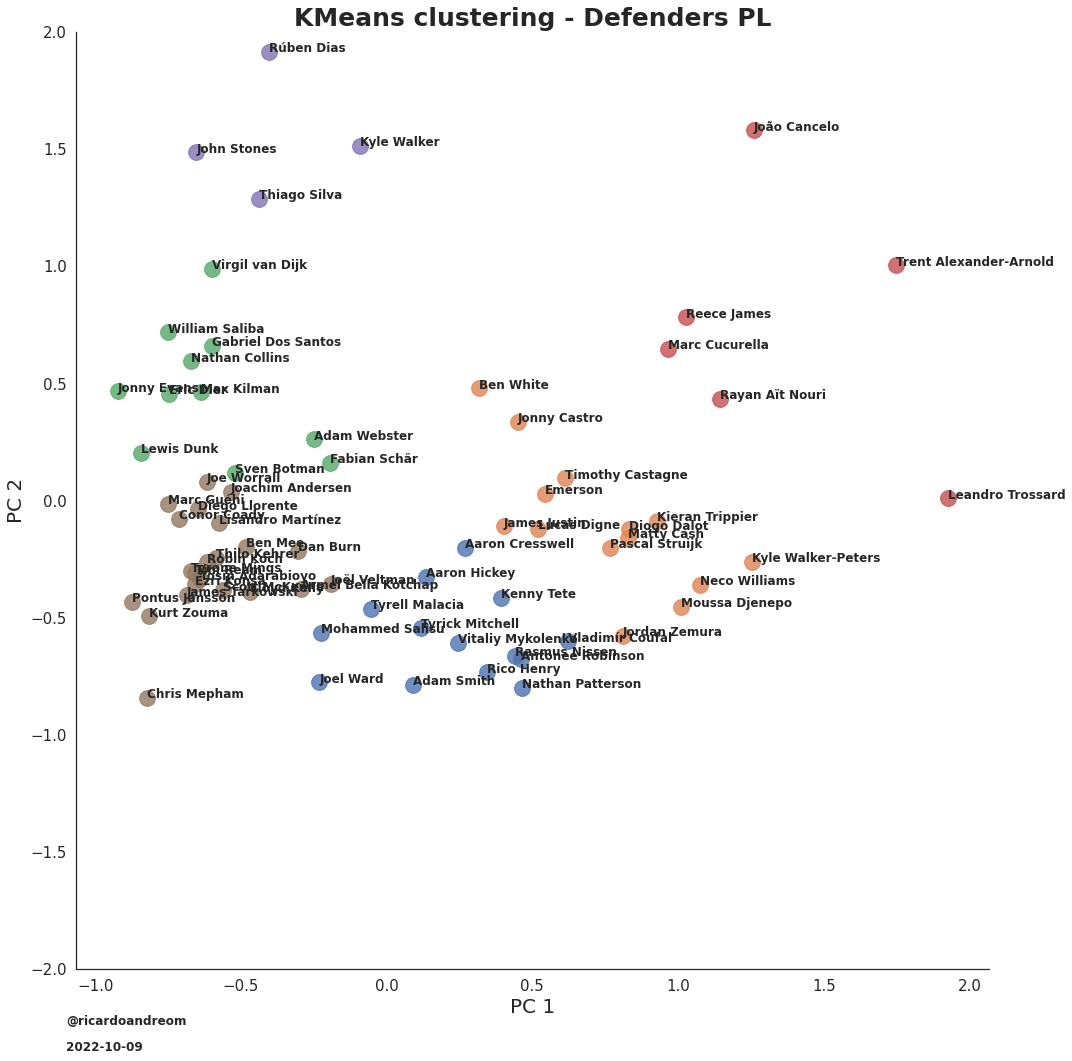

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = reduced, legend=False,
                   fit_reg=False, size = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s,fontweight='heavy'))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)
plt.title('KMeans clustering - Defenders',size=25,weight='heavy')

s ="@ricardoandreom\n"
date = datetime.today()
d = str(date.strftime('%Y-%m-%d'))
plt.text(-1.1,-2.3, s, fontdict=None, fontsize=12, fontweight='heavy')
plt.text(-1.1,-2.35, d, fontdict=None, fontsize=12, fontweight='heavy')
date = datetime.today()

plt.tight_layout()


**Cluster 5**

It's always a personal opinion, but in this cluster are the best full backs in the Premier League in this start of the season.

*   Ofensive, progressive and very good technical players



In [ ]:
reduced[reduced["cluster"]==5]['name']

1            Rayan Aït Nouri
2     Trent Alexander-Arnold
7               João Cancelo
15            Marc Cucurella
28               Reece James
59          Leandro Trossard
Name: name, dtype: object

**Cluster 4**

In [ ]:
reduced[reduced["cluster"]==4]['name']

17         Rúben Dias
52       Thiago Silva
54        John Stones
60    Virgil van Dijk
62        Kyle Walker
Name: name, dtype: object

This clusters is clearly representing a small set of the top center backs in the league, maybe it's missing some of them.

Personally I'd expect to see Saliba in this cluster.

Interestingly, Kyle walker, who is still a full-back is in this cluster. However Guardiola over the years has converted him in more of a center back, occupying this role several times.

**Cluster 0**

**Above average performing full backs**

In [ ]:
reduced[reduced["cluster"]==0]['name']

8             Matty Cash
9       Timothy Castagne
10          Jonny Castro
16           Diogo Dalot
19           Lucas Digne
20        Moussa Djenepo
23               Emerson
30          James Justin
55        Pascal Struijk
58       Kieran Trippier
63    Kyle Walker-Peters
66             Ben White
67         Neco Williams
Name: name, dtype: object

**Cluster 3**

In [ ]:
reduced[reduced["cluster"]==3]['name']

13      Vladimír Coufal
14      Aaron Cresswell
26           Rico Henry
27         Aaron Hickey
37       Tyrell Malacia
43      Tyrick Mitchell
44    Vitaliy Mykolenko
45        Rasmus Nissen
46     Nathan Patterson
48     Antonee Robinson
53           Adam Smith
57           Kenny Tete
69        Jordan Zemura
Name: name, dtype: object

**Cluster 2**

In [ ]:
reduced[reduced["cluster"]==2]['name']

0        Tosin Adarabioyo
4     Armel Bella Kotchap
6                Dan Burn
11            Conor Coady
25             Marc Guéhi
29         Pontus Jansson
31           Thilo Kehrer
32            Lloyd Kelly
34             Robin Koch
35             Ezri Konsa
36         Diego Llorente
38      Lisandro Martínez
39          Scott McKenna
40                Ben Mee
41           Chris Mepham
42           Tyrone Mings
47               Tim Ream
50        Mohammed Salisu
56        James Tarkowski
61           Joël Veltman
64              Joel Ward
70             Kurt Zouma
Name: name, dtype: object

**Cluster 1**

In [ ]:
reduced[reduced["cluster"]==1]['name']

3       Joachim Andersen
5            Sven Botman
12        Nathan Collins
18             Eric Dier
21    Gabriel Dos Santos
22            Lewis Dunk
24           Jonny Evans
33            Max Kilman
49        William Saliba
51          Fabian Schär
65          Adam Webster
68           Joe Worrall
Name: name, dtype: object

# 3d K-means clustering

Now, let's use df_3d and in an analogous way reduce to 3 dimensions using PCA. This way we can plot our players and look for relationships in a 3D analysis.





In [ ]:
from sklearn import preprocessing

player_names_3d = df_3d['Player'].tolist() 

df_3d = df_3d.drop(['Player'], axis = 1) 

x = df_3d.values 
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
df1 = pd.DataFrame(pca.fit_transform(X_norm))
df1.head()

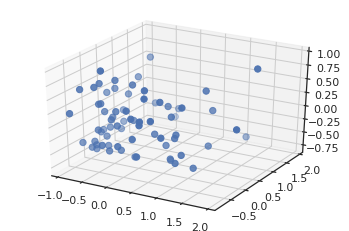

Text(0, 0.5, 'WCSS')

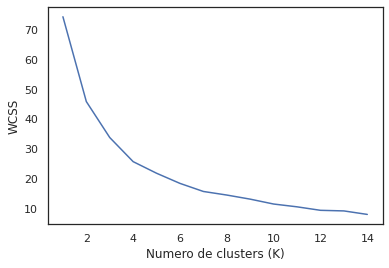

In [ ]:
import re, seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


%matplotlib inline
df1.columns = ['PC1','PC2', 'PC3']

ax = plt.figure().gca(projection='3d')

ax.scatter(df1['PC1'], df1['PC2'], df1['PC3'], s=40)

plt.show()

wcss = [] 
for i in range(1, 15): 
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans.fit(df1) 
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 15), wcss)
plt.xlabel('Numero de clusters (K)')
plt.ylabel('WCSS')

In [ ]:
kmeans = KMeans(n_clusters=9)
kmeans = kmeans.fit(df1)

labels = kmeans.predict(df1)
clusters = kmeans.labels_.tolist()

df1['cluster'] = clusters
df1['name'] = player_names
df1.columns = ['x', 'y', 'z', 'cluster', 'name']
df1

,x,y,z,cluster,name
0,-0.639051,-0.338125,-0.450186,3,Tosin Adarabioyo
1,1.145303,0.432487,-0.399182,2,Rayan Aït Nouri
2,1.749324,1.003704,0.934118,2,Trent Alexander-Arnold
3,-0.534441,0.036560,-0.032248,8,Joachim Andersen
4,-0.293951,-0.378632,0.091178,3,Armel Bella Kotchap
5,-0.519228,0.117903,0.620235,6,Sven Botman
6,-0.304308,-0.214421,0.187277,6,Dan Burn
7,1.260826,1.579869,-0.579385,2,João Cancelo
8,0.829139,-0.161262,-0.121493,5,Matty Cash
9,0.611402,0.093884,0.151858,7,Timothy Castagne


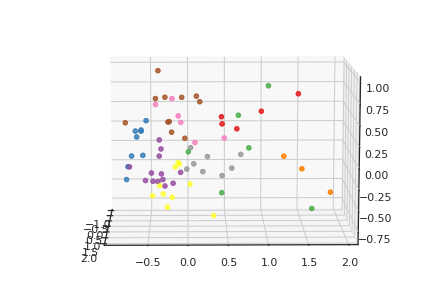

In [51]:
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)

def init():
    ax.scatter(df1['x'], df1['y'], df1['z'], marker='o', s=20, c=df1['cluster'], cmap=plt.get_cmap('Set1'), alpha=0.6)
    texts = []
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)

anim.save('clusters_animation.mp4', fps=60, extra_args=['-vcodec', 'libx264'],dpi=300)